Importing Libraries

In [2]:

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings('ignore')
# necessary regression models
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.svm import LinearSVR, SVR

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#preprocessing
from sklearn.preprocessing import Normalizer, StandardScaler #works on rows and not cols
from scipy import stats
# importing the metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# hyper parameter tuning
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
import optuna

read the file

In [3]:

#reading the file
train = pd.read_csv('/home/rhythm/Research/ml/dataset-cosTH/train.csv', delimiter=";", header = 0)

checking the dtype of the data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   evt     50001 non-null  object
 1   E1      50001 non-null  object
 2   E2      50001 non-null  object
 3   t1      50001 non-null  object
 4   t2      50001 non-null  object
 5   x1      50001 non-null  object
 6   y1      50001 non-null  object
 7   z1      50001 non-null  object
 8   x2      50001 non-null  object
 9   y2      50001 non-null  object
 10  z2      50001 non-null  object
 11  costh   50001 non-null  object
dtypes: object(12)
memory usage: 4.6+ MB


converting dtype

In [5]:
for cols in train.columns :
    train[cols] = pd.to_numeric(train[cols], errors='coerce')
    

Data Cleaning
1. removing obsoltete values
2. dropping NaN

In [6]:
train['t1'] = train.t1.replace(-5.000000e-09, 0)
train['t2'] = train.t2.replace(-5.000000e-09, 0)
train = train.dropna()

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50000
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   evt     50000 non-null  float64
 1   E1      50000 non-null  float64
 2   E2      50000 non-null  float64
 3   t1      50000 non-null  float64
 4   t2      50000 non-null  float64
 5   x1      50000 non-null  float64
 6   y1      50000 non-null  float64
 7   z1      50000 non-null  float64
 8   x2      50000 non-null  float64
 9   y2      50000 non-null  float64
 10  z2      50000 non-null  float64
 11  costh   50000 non-null  float64
dtypes: float64(12)
memory usage: 5.0 MB


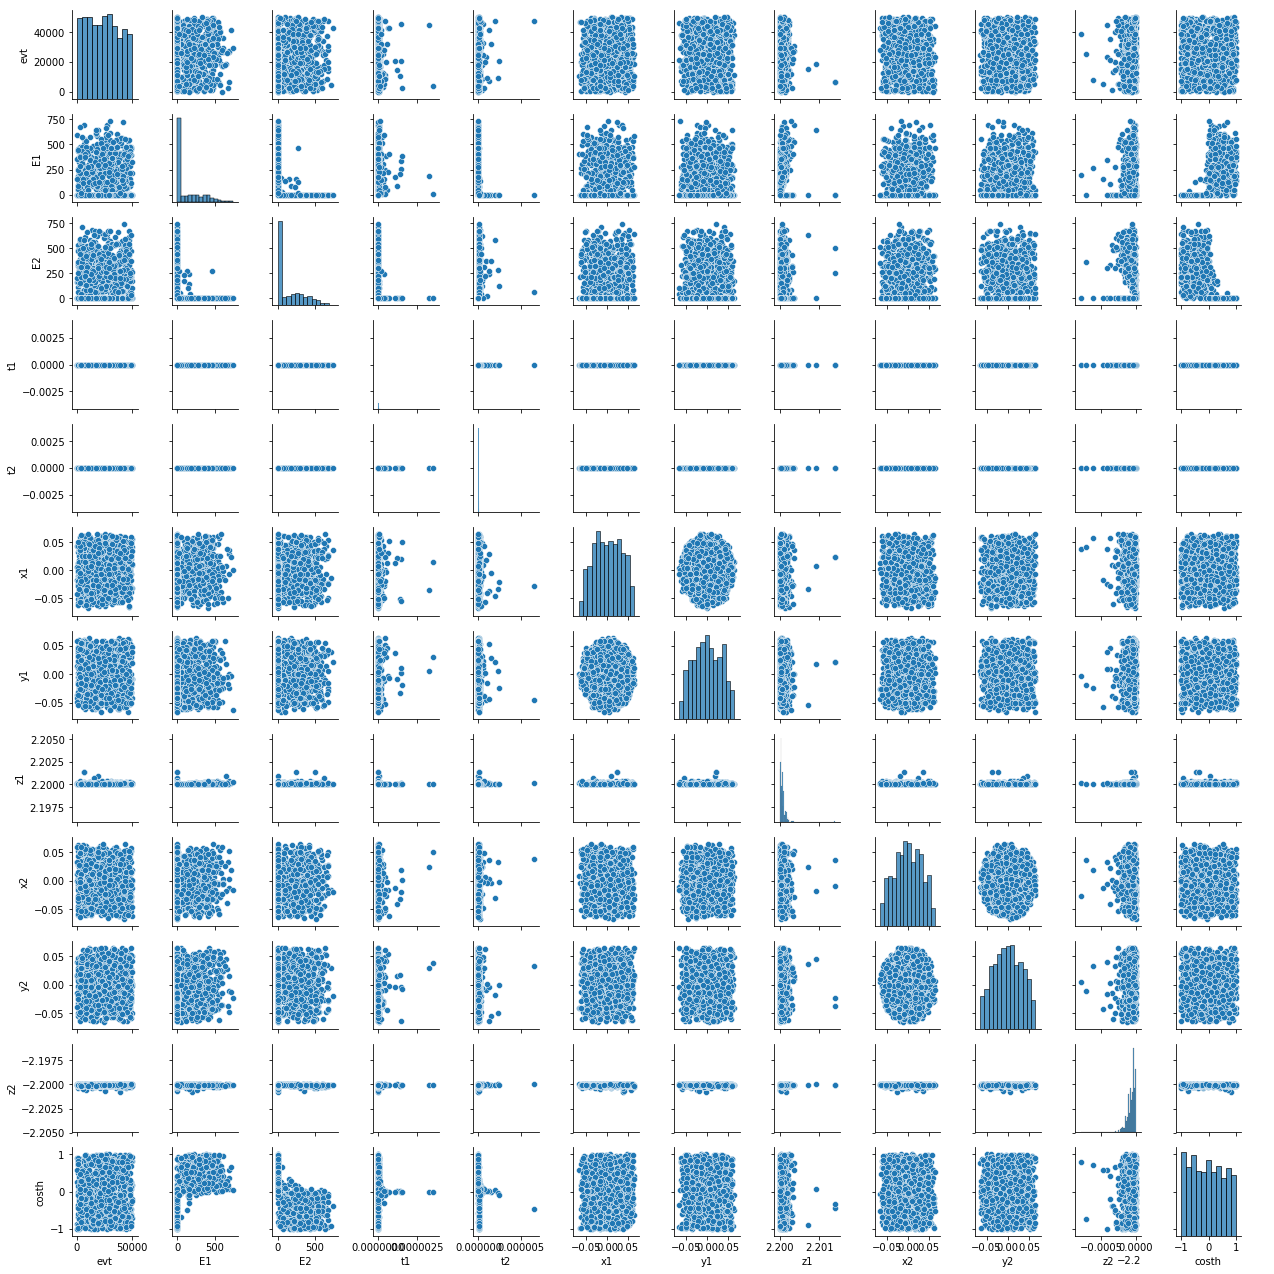

In [8]:
sns.pairplot(data = train.sample(1000), height = 1.5)

In [ ]:
corr = train.corr()

In [ ]:
#let's look at the correlation matrix
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot = True, fmt =".2f"
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

graphical representation of the featues 

In [8]:
def plot_columns(df, type) :
    fig,ax = plt.subplots(4,3, figsize = (10,12))
    ax = ax.flatten()
    for i, col in enumerate(df.columns):
        if type == 'boxplot' : 
            sns.set_style("whitegrid",{'axes.grid':True} )
            sns.boxplot(y = df[col], width = 0.3, ax=ax[i], palette="Set2", linewidth=2, 
                        showmeans = True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"yellow"},
                        dodge = False)
        if type == 'distribution'  :
            sns.histplot(data=df, ax = ax[i], color = 'blue', x = col, kde = True)
        if type == 'scatter':
            sns.scatterplot( y = col, x = 'costh', data = df,ax = ax[i],
                        color = 'blue',alpha=0.4 )
    
    return fig.tight_layout()
    


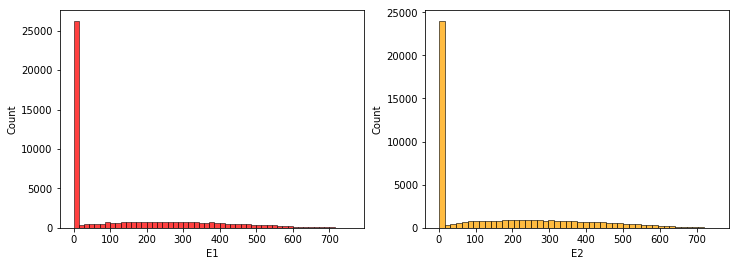

In [9]:
fig,ax = plt.subplots(1,2, figsize =(12, 4))
ax = ax.flatten()
sns.histplot(x = 'E1', data = train, color = 'red', ax = ax[0])
sns.histplot(x = 'E2', data = train, color = 'orange', ax = ax[1])

In [ ]:
# number of features 
p = train.shape[1]
display(p-1)

 X and Y

In [19]:
#removing the outliers or the rows corresponding to the 
# costh < 0 and E1 > 200
outlier1 =  train.loc[(train['E1'] > 200 )&( train['costh'] < 0)]
outlier2 = train.loc[(train['E2'] > 200 )&( train['costh'] > 0)]

In [12]:
X = train.drop(['evt','costh'], axis =1 )
y = train['costh']

#train.isna().sum()
#train

In [20]:
train_set = train.drop(outlier1.index, axis = 0)
train_set = train_set.drop(outlier2.index, axis = 0)
X_trainset = train_set.drop(['costh', 'evt'], axis = 1)
y_trainset = train_set.costh

splitting train test

In [18]:
#splitting into validation and training dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_trainClean, X_valClean, y_trainClean, y_valClean = train_test_split(X_trainset, y_trainset, test_size = 0.3, random_state = 42)

# Transforming Data

In [21]:

sc=StandardScaler()
X_train_std = sc.fit_transform(X_train)
y_train_std = sc.fit_transform(y_train.values.reshape(-1, 1))
X_val_std = sc.transform(X_val)
y_val_std = sc.transform(y_val.values.reshape(-1,1))
#applying on the clean data set
X_clean_train_std = sc.fit_transform(X_trainClean)
y_clean_train_std = sc.fit_transform(y_trainClean.values.reshape(-1, 1))
X_clean_val_std = sc.transform(X_valClean)



In [163]:
X_train_transformed['E1'][45932]

0.0

## 2. BOXCOX Transformation
2.1 just transform the features 

2.2 transform the entire dataset
https://www.kaggle.com/code/pmarcelino/data-analysis-and-feature-extraction-with-python [ref]

2.3 the data needs to be strictly +ve no zero values allowed either . https://stackoverflow.com/questions/50180988/valueerror-data-must-be-positive-boxcox-scipy [ref]

In [170]:
X_train_transformed = X_trainset.copy()
df_boxcox = pd.DataFrame()
i = 0
for col in X_train_transformed.columns:
    i = i +1
    if col == 'E2':
        print(col)
        positive_index = X_train_transformed[col] > 0
        zero_index = X_train_transformed[col] ==0
        print(positive_index.shape)
        #print(zero_index)
        positive_col = X_train_transformed[col].loc[positive_index]
        print(positive_col.shape)
        zero_col = X_train_transformed[col].loc[zero_index]
        print(zero_col.shape)
        bcdata, lam = stats.boxcox(positive_col)
        if lam > 0 :         
            print('lambda :', lam)
            print(bcdata.shape)
            X_train_transformed[col].loc[positive_index] = bcdata
            X_train_transformed[col].loc[zero_index] = -1/lam
        #   x = np.empty_like(trans)
    #   print(x.shape)
    #        x[X_train_transformed[col].values>0] = bcdata
    #        x[X_train_transformed[col].values == 0] = -1/lam
  #  df_boxcox = x
       # transformed = np.empty_like(X_train_transformed['E2'])
       # transformed[X_train_transformed['E2'] > 0] = bcdata
       # transformed[X_train_transformed['E2'] == 0] = -1/lam
       # sns.histplot(transformed)
#sns.histplot(X_train_transformed.E2)

E2
(49265,)
(25697,)
(23568,)
lambda : 0.6184107062960477
(25697,)


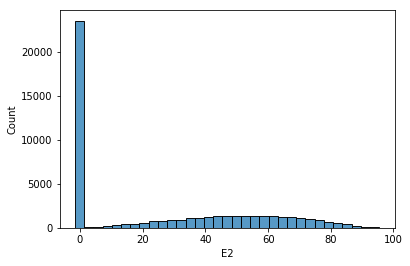

In [169]:
sns.histplot(X_train_transformed['E2'])

In [110]:
X_train_transformed[X_train_transformed['E2'].values>0].shape

(25697, 10)

In [ ]:
cols_name = [cols for cols in X.columns]
X_train_std_df = pd.DataFrame(data = X_train_std,columns = cols_name )
X_train_std_df.dropna()

In [ ]:
fig,ax = plt.subplots(4,3, figsize = (10,12))
ax = ax.flatten()
for i, col in enumerate(X_train_std_df.columns):
    sns.set_style("whitegrid",{'axes.grid':True} )
    sns.boxplot(y = X_train_std_df[col], width = 0.3, ax=ax[i], palette="Set2", linewidth=2, 
                ,dodge = False)
fig.tight_layout()


In [ ]:
#Linear Regression
#from locale import normalize
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_std, y_train_std)

In [ ]:
corr_std = X_std_df.corr()

In [ ]:
#let's look at the correlation matrix
sns.pairplot(data = X_std_df.sample(2000), height = 1.5)

## using cross-validation
setting up 5 cross - validation using KFold to get consisent validation dataset

In [ ]:
from sklearn.model_selection import KFold
KFold = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [177]:
X_train = train.drop(['evt','costh'], axis = 1).values
y_train = train.costh

## 1. Linear Regression

In [12]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, X_train, y_train, cv = KFold, n_jobs = -1, scoring = 'neg_mean_squared_error')
lin_rmse_scores = np.sqrt(-scores)
print('Linear Regression performance :', lin_rmse_scores)

NameError: name 'X_train' is not defined

## 2. Decision Tree Regressor

In [ ]:
print(sklearn.metrics.SCORERS.keys())

In [ ]:
%%time
from sklearn.model_selection import KFold
KFold = KFold(n_splits = 5, shuffle = True, random_state = 42)
from sklearn.tree  import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor(random_state = 42)
scores = cross_val_score(tree_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
tree_rmse_scores = np.sqrt(-scores)
print('Decision Tree Regressor performance:', tree_rmse_scores)

## 3. Random Forest Regressor

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
forest_reg = RandomForestRegressor(random_state = 42)
scores = cross_val_score(forest_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
forest_rmse_scores = np.sqrt(-scores)
print('Forest Regressor performance:', forest_rmse_scores)

## 4. LGBM

In [ ]:
%%time
from lightgbm import LGBMRegressor
lgbm_reg = LGBMRegressor(random_state = 42)
scores = cross_val_score(lgbm_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
lgbm_rmse_scores = np.sqrt(-scores)
print('LGBM Regressor performance:', lgbm_rmse_scores)

In [ ]:
%%time
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
xgb_reg = XGBRegressor(random_state = 42)
scores = cross_val_score(xgb_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
xgb_rmse_scores = np.sqrt(-scores)
print('XGB Regressor performance:', xgb_rmse_scores)

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
cat_reg = CatBoostRegressor(random_state = 42)
scores = cross_val_score(cat_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
cat_rmse_scores = np.sqrt(-scores)
print('Cat Regressor performance:', cat_rmse_scores)

* smaller the MSE better the model - CatBoost , XGB, LGB Regressor works well
* we see decision tree regressor has the best score amongs other regressor fit

## Model Results

In [ ]:
from sklearn.model_selection import cross_val_predict
y_predict = cross_val_predict(tree_reg, X_train, y_train, cv = KFold, n_jobs = -1)


In [ ]:
fig = plt.figure(figsize=(10, 4), facecolor='#f6f6f6')
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
gs.update(wspace=0.2, hspace=0)
background_color = "#f6f6f6"

sns.scatterplot(y_train, y_train, ax=ax0, color='blue', alpha = 0.7, linewidth=0.3, edgecolor='#5a0012', zorder=3)
sns.scatterplot(y_predict, y_train, ax=ax0, color='pink', alpha = 0.8,linewidth=0.3, edgecolor='#4f4100', zorder=3)

sns.kdeplot(y_train, ax=ax1, color='yellow', shade=True, linewidth=1.5, alpha=0.8, zorder=3, legend=False)
sns.kdeplot(y_predict, ax=ax1, color='pink', shade=True, linewidth=1.5, alpha=0.5, zorder=3, legend=False)


ax0.set_ylabel('target')
ax0.set_xlabel('prediction')
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.grid(which='major', zorder=0, color='gray', linestyle=':', dashes=(1,5))
ax1.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))




do the polynomial regression too ! 
read about what parameters can be extracted 

## Hyperparameter tuning 
to get better result using OPTUNA

In [ ]:
import optuna
from lightgbm import LGBMRegressor
def objective (trial):
    params ={
        'random_state':42,
        'max_depth' : int(trial.suggest_loguniform('max_depth', 1, 32)),
        'n_estimators' : trial.suggest_int('n_estimators', 2, 20),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1.0)
    }
    lgbm_reg = LGBMRegressor()
    lgbm_reg.set_params(**params)
    scores = cross_val_score(lgbm_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
    lgbm_rmse_scores = np.sqrt(-scores)
    return np.mean(lgbm_rmse_scores)


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
trial = study.best_trial
print('RMSE : %.3f' %(trial.value))
print('Best Hyperparameters : ', (trial.params))

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
lgbm_reg = LGBMRegressor(max_depth= 6, n_estimators= 20, learning_rate= 0.2560675465882839, random_state=42)
lgbm_reg.fit(X_train, y_train)


In [ ]:
from sklearn.model_selection import cross_val_predict
y_predict_lgbm = cross_val_predict(lgbm_reg, X_train,y_train, cv = KFold , n_jobs = -1)

In [ ]:
y_predict_lgbm

In [ ]:
residual = (y_predict_lgbm - y_train)#/y_train
plt.scatter(y = y_predict_lgbm, x = y_train,   color = 'blue',alpha = 0.2)

In [ ]:
ax = sns.scatterplot(x = y_predict_lgbm, y = residual, color = 'blue', alpha = 0.2 )
#ax.set(ylim = (-2.0, 2.0))
sns.set_style('whitegrid')
ax.set_ylabel('residual')
ax.set_xlabel('y_predicted')


In [ ]:
sns.histplot(residual, color = 'orange')
#we notice the residual is normally dstributed 
# and there is no preference towards a particular direction

In [ ]:
sns.histplot(y_predict_lgbm, color = 'yellow')
sns.histplot(y_train, color = 'orange')

feature importance using  lgbm regressor

In [ ]:
#plot the residual


In [ ]:

feature_imp = pd.DataFrame(sorted(zip(lgbm_reg.feature_importances_, X_train.columns)), columns = ['Value', 'Feature'])
plt.figure(figsize=(14,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

checkning the parameterization for CatBoostRegressos


In [ ]:
def objective (trial):
    params ={
        'random_state':42,
        'depth' : int(trial.suggest_loguniform('max_depth', 1, 16)),
        'iterations' : trial.suggest_int('iterations', 2, 10),
        'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.01)
    }
    cat_reg = CatBoostRegressor()
    cat_reg.set_params(**params)
    scores = cross_val_score(cat_reg,X_train, y_train, scoring = 'neg_mean_squared_error', cv = KFold, n_jobs=-1)
    lgbm_rmse_scores = np.sqrt(-scores)
    return np.mean(lgbm_rmse_scores)


In [ ]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
trial = study.best_trial
print('RMSE : %.3f' %(trial.value))
print('Best Hyperparameters : ', (trial.params))
optuna.visualization.plot_optimization_history(study)

## 5. Polynomial Regression

## 6. Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

enReg = ElasticNet()
enReg.fit(X_train, y_train)
y_pred = enReg.predict(X_train)

In [ ]:
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
#print(f'accuracy error {accuracy_score(y_pred, y_train)}')
print(f'r2_score {r2_score(y_pred, y_train)}')
print(f'mean squared error {mean_squared_error(y_pred, y_train)}')

MSE can be low in situation of under fitting, where there are too many degrees of freedom available to Residual space and too few to the Regressor space, this in turn can lead to small R2 also if the contributing regressors in the present regression model do not contribute to much of data variation.

Hence, introducing the more number of features

## 7. Polynomial Regression

In [25]:

poly = PolynomialFeatures(degree = 4)
lin_reg = LinearRegression()
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)


In [26]:
#fitting the model 
lin_reg.fit(X_train_poly, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
y_train_pred_poly = lin_reg.predict(X_train_poly)
y_val_pred_poly = lin_reg.predict(X_val_poly)

In [41]:
print('RMSE : ', np.sqrt(mean_squared_error(y_val_pred_poly, y_Val)))
print('MAE : ', (mean_absolute_error(y_val_pred_poly, y_Val)))

RMSE :  3620.0314940389117
MAE :  32.87006371265097


In [31]:
print(lin_reg.score(X_val_poly, y_val_pred_poly))

1.0


# DANGER ! 
so many coef !

In [42]:
lin_reg.coef_

array([  7.86489949, -19.86438049,  42.26208038, ...,  -0.23841513,
        -6.96226586,  22.11519748])

(-1.0, 1.0)

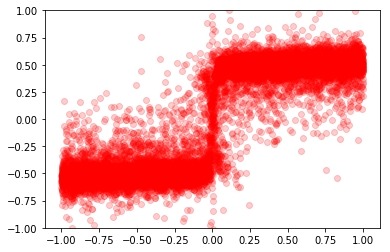

In [38]:
plt.scatter(y_Val, y_val_pred_poly, color = 'red', alpha = 0.2)
plt.ylim(-1.0, 1.0)

## Models!

In [11]:
models = {
    'Elastic Net' : ElasticNet(random_state=42),
    'Lasso'       : Lasso(random_state=42),
    'Linear Regression' : LinearRegression(),
    'Ridge'       : Ridge(random_state=42),
    'Linear SVR ' : LinearSVR(random_state=42), 
    'SVR'         : SVR(), 
    'GradBoostReg': GradientBoostingRegressor(random_state=42),
    'RandomForest':  RandomForestRegressor(random_state=42),
    'XGBoost'     : XGBRegressor(random_state=42),
    'LGBM'        : LGBMRegressor(random_state=42),
    'AdaBoost'    : AdaBoostRegressor(random_state=42),
    
}

In [10]:
#initialising the meterics
def models_evaluation(title, model, X_train, y_train, X_val, y_val):
    rmse = []
    r2scores = []
    mae = []
    pred_df = pd.DataFrame()
    i = 0
    # running through the model content
    for m in model.values():
        i = i +1
        m.fit(X_train, y_train)
        y_pred= m.predict(X_val)
        pred_df[i] = y_pred
        rmse.append(np.sqrt(mean_squared_error(y_pred, y_val)))
        r2scores.append(r2_score(y_pred, y_val))
        mae.append(mean_absolute_error(y_pred, y_val))

    #plotting the model name and relative error and 
    fig,ax = plt.subplots(1,2, figsize = (12,6))
    ax = ax.flatten()
 
    ax[0].plot(model.keys(), rmse,marker ='o', color = 'red', label = 'rmse')
    ax[0].plot(model.keys(), mae, marker ='s',color = 'blue', label = 'mae')
    ax[1].plot(model.keys(), r2scores,marker ='*', color = 'green', label = 'r2-score')

   
    fig.suptitle(title)
    for i in range (0,2):
        ax[i].grid()
        ax[i].legend()
        ax[i].set_ylabel("Error")
        ax[i].set_xticklabels(model.keys(), rotation = 30)
        ax[i].set_ylim(0.0, 1.0)
    return (plt.show())


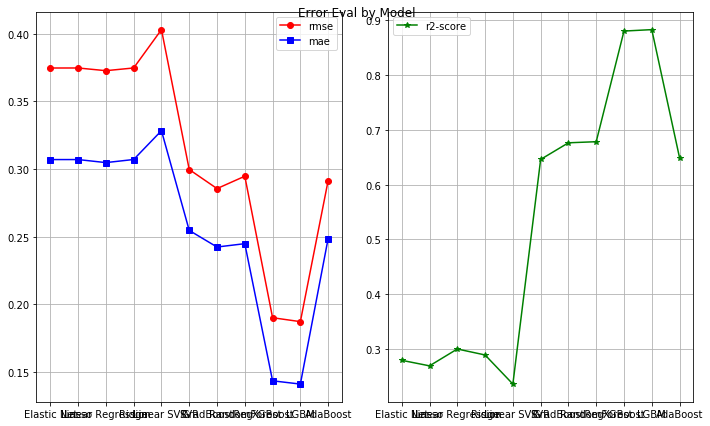

In [48]:
models_evaluation(model = models, X_train =X_trainClean, y_train =y_trainClean, X_val = X_valClean, y_val = y_valClean)

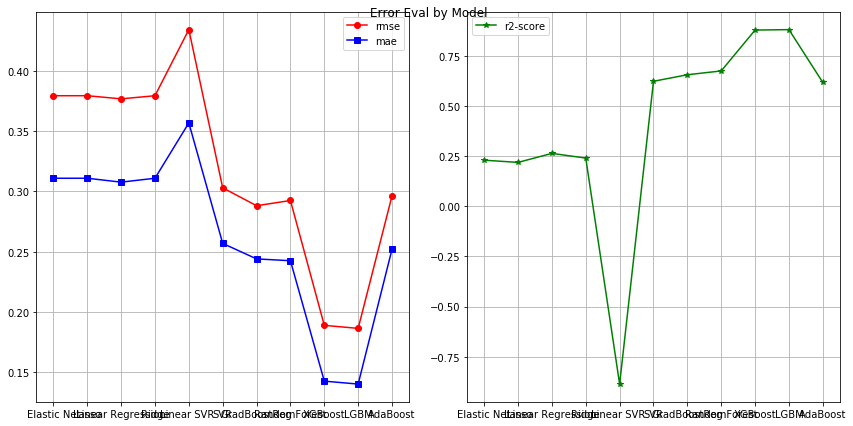

In [50]:
models_evaluation(model=models, X_train=X_train, y_train=y_train, X_val=X_val, y_val= y_val)

we can see from the two graphs above that the performance is yet similar with LGBM performing slightly better than the XGBoost. the MSE and r2-scoers are roughtly the same. However, we will proceed with the one without the outlier

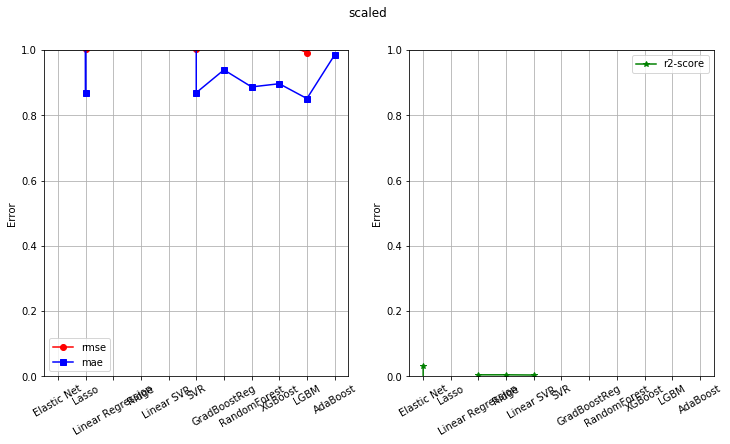

In [65]:
#running for the scaled data
models_evaluation(title = "scaled",model=models, X_train=X_train_std, y_train=y_train_std, X_val=X_val_std, y_val= y_val_std)

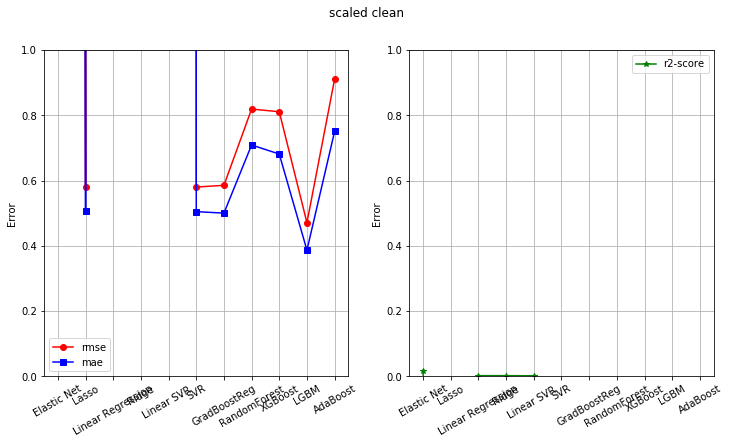

In [67]:
models_evaluation(title = "scaled clean ",model=models, X_train=X_clean_train_std, y_train=y_clean_train_std, X_val=X_clean_val_std, y_val= y_valClean)

OBSERVATION
 * the scaling doesn gives high error and very low r2_score
 * cleaning the data gives roughly the same values. 
 Hence, using the cleaned data (without scaling ) for the next analysis with the models. 


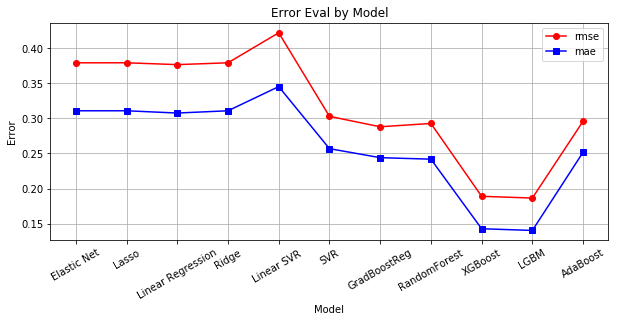

In [98]:
#plotting the model name and relative error and 
plt.figure(figsize=(10,4))
plt.plot(models.keys(), rmse,marker ='o', color = 'red', label = 'rmse')
plt.plot(models.keys(), mae, marker ='s',color = 'blue', label = 'mae')
#plt.plot(models.keys(), r2scores,marker ='*', color = 'green', label = 'r2-score')
plt.xlabel('Model')
plt.xticks(rotation = 30)
plt.ylabel('Error')
plt.title('Error Eval by Model')
plt.grid()
plt.legend()
plt.show()

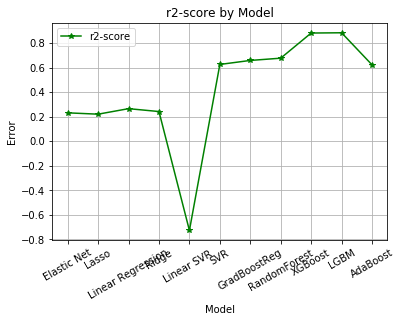

In [99]:
plt.plot(models.keys(), r2scores,marker ='*', color = 'green', label = 'r2-score')
plt.xlabel('Model')
plt.xticks(rotation = 30)
plt.ylabel('Error')
plt.title('r2-score by Model')
plt.grid()
plt.legend()
plt.show()

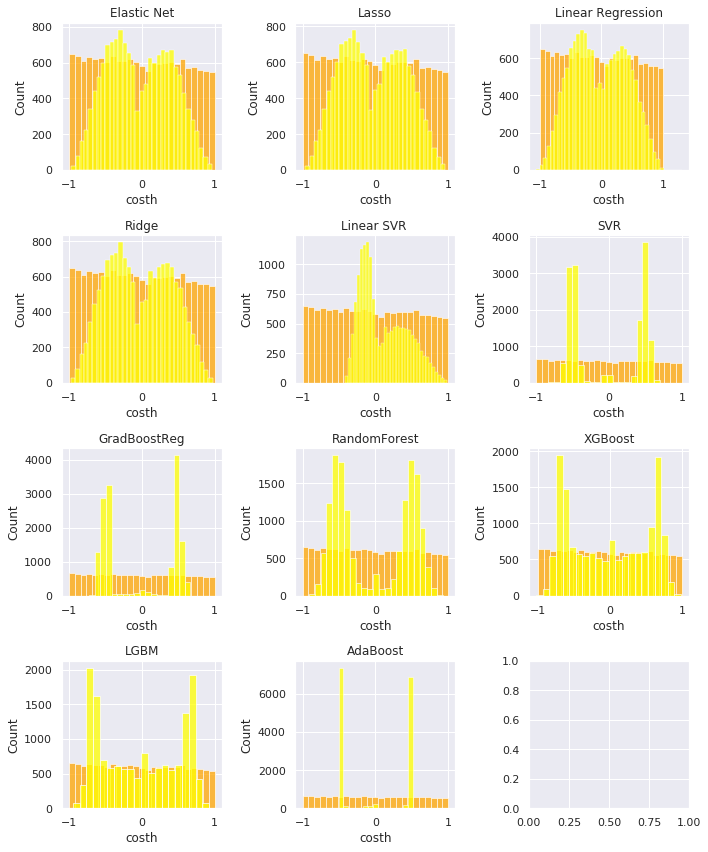

In [118]:
# check the plot of the predicted target value
# versus the true vals
pred_df = pred_df.set_axis(models.keys(), axis = 1, inplace= False)
fig,ax = plt.subplots(4,3, figsize = (10,12))
ax = ax.flatten()
for i, col in enumerate(pred_df.columns):
    sns.histplot(y_Val, color = 'orange', ax = ax[i] )
    sns.histplot(pred_df[col], color = 'yellow', ax = ax[i]).set(title = col)
    
fig.tight_layout()

one needs to see what happens if we chhose -0.75 to 0.75. Since

# HYPERPARAMETER TUNING
once the model is chosen running through the hyper-parameter tuning to choose the appropriate

1. GridSearchCV
2. Hyperopt
3. Optuna

## optuna 
Runinng the optuna model on the XGboost, LGBM and, elastic net

In [37]:
#combining the parameters we can get from tuning the model
def tune(objective):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    trial = study.best_trial
    params = study.best_params
    bestScore = study.best_value
    print('RMSE : %.3f' %(bestScore))
    print('Best Hyperparameters : ', (params))
    return params

In [33]:
def rmse_cv(model, X, y):
    # 5 fold cross Valid
    kFold = KFold(n_splits= 5, shuffle = True, random_state= 42)
    scores = cross_val_score(model,X, y, scoring = 'neg_mean_squared_error', cv = kFold, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores
    

### 1. LGBM objective function

In [35]:
# defining optiminsing model for LGBM
def lgbm_objective (trial):
    params ={
        'random_state':42,
        "verbosity": -1,
        'max_depth' : int(trial.suggest_loguniform('max_depth', 1, 32)),
        'n_estimators' : trial.suggest_int('n_estimators', 2, 20),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1.0)
    }
    X = X_trainset
    y = y_trainset
    lgbm_reg = LGBMRegressor()
    lgbm_reg.set_params(**params)
  
    return np.mean(rmse_cv(lgbm_reg, X, y))


In [ ]:
tune(lgbm_objective) # results for the X, y when no cleaning no scaling

RMSE : 0.187

Best Hyperparameters :  {'max_depth': 5.2563886157212325, 'n_estimators': 18, 'learning_rate': 0.2742560932362402}

{'max_depth': 5.2563886157212325,
 'n_estimators': 18,
 'learning_rate': 0.2742560932362402}

In [ ]:
tune(lgbm_objective)

RMSE : 0.188
Best Hyperparameters :  {'max_depth': 5.079437316018941, 'n_estimators': 19, 'learning_rate': 0.2541935446323036}
{'max_depth': 5.079437316018941,
 'n_estimators': 19,
 'learning_rate': 0.2541935446323036}

### 2 . XGBoost objectibve function

In [24]:
def xgb_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _gamma = trial.suggest_float("gamma", 0.01, 1)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)
    
    xgb = XGBRegressor(n_estimators = _n_estimators, max_depth = _max_depth,
                       learning_rate = _learning_rate, gamma = _gamma, min_child_weight = _min_child_weight,
                        subsample =_subsample,reg_alpha =_reg_alpha,reg_lambda = _reg_lambda )
    return np.mean(rmse_cv(xgb))

In [ ]:
tune(xgb_objective)

### 3. Elastic Net

In [189]:
def elasticnet_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.0001, 1)
    _l1_ratio = trial.suggest_float("l1_ratio", 0.01, 1)

    elastic = ElasticNet(alpha=_alpha, l1_ratio=_l1_ratio, random_state=42)  
    return np.mean(rmse_cv(elastic))

In [ ]:
tune(elasticnet_objective)

RMSE : 0.378

Best Hyperparameters :  {'alpha': 0.4467439962425363, 'l1_ratio': 0.010397453436086534}

{'alpha': 0.4467439962425363, 'l1_ratio': 0.010397453436086534

### checking the best parameter results
1. LGBM

In [206]:
lgbm_params = {'max_depth': 5, 'n_estimators': 18, 'learning_rate': 0.2742560932362402}

In [207]:
lgbm_reg = LGBMRegressor()
lgbm_reg.set_params(**lgbm_params)
lgbm_reg.fit(X_train, y_train)
y_pred_lgbm = lgbm_reg.predict(X_val)
print('RMSE', np.sqrt(mean_squared_error(y_pred_lgbm, y_Val)))
print('r2_score', r2_score(y_pred_lgbm, y_Val))
print('mean_absolute Error', mean_absolute_error(y_pred_lgbm, y_Val))

RMSE 0.1821776390149606
r2_score 0.8876301438288133
mean_absolute Error 0.1378963334141493


[Text(0.5, 1.0, 'LGBM')]

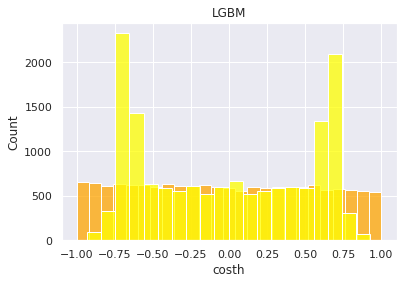

In [210]:
sns.histplot(y_Val, color = 'orange')
sns.histplot(y_pred_lgbm, color = 'yellow').set(title = 'LGBM')
    

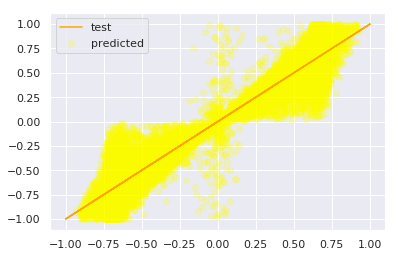

In [221]:

plt.scatter(y_pred_lgbm, y_Val, color = 'yellow', alpha = 0.2, label = 'predicted')
plt.plot(y_Val, y_Val, color = 'orange', label = 'test')
plt.legend()

2. Elastic Net

In [219]:
elasticNetParams = {'alpha': 0.4467439962425363, 'l1_ratio': 0.010397453436086534 }
elastic = ElasticNet(alpha = 0.4467439962425363, l1_ratio=0.010397453436086534, random_state= 42)
elastic.fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_val)
print('RMSE', np.sqrt(mean_squared_error(y_pred_elastic, y_Val)))
print('r2_score', r2_score(y_pred_elastic, y_Val))
print('mean_absolute Error', mean_absolute_error(y_pred_elastic, y_Val))

RMSE 0.3793524963082514
r2_score 0.2396608417783206
mean_absolute Error 0.3109034147121952


[Text(0.5, 1.0, 'Elatsic Net')]

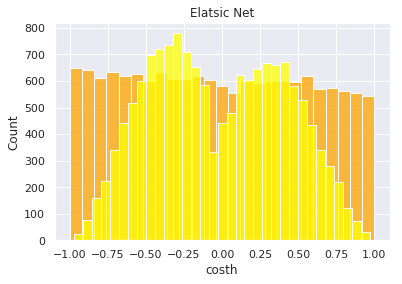

In [222]:
sns.histplot(y_Val, color = 'orange')
sns.histplot(y_pred_elastic, color = 'yellow').set(title = 'Elatsic Net')

Text(0.5, 1.0, 'ElasticNet')

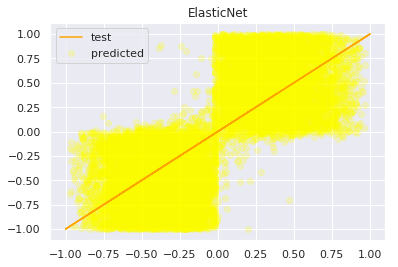

In [223]:

plt.scatter(y_pred_elastic, y_Val, color = 'yellow', alpha = 0.2, label = 'predicted')
plt.plot(y_Val, y_Val, color = 'orange', label = 'test')
plt.legend()
plt.title('ElasticNet')

## Grid CV

## Hyper Opt

# Outlier detection 
E_1 and E_2 is not showing the mean, 
some outliers
# Neural Network


## Exploring skewness and looking at its impact

IndexError: index 12 is out of bounds for axis 0 with size 12

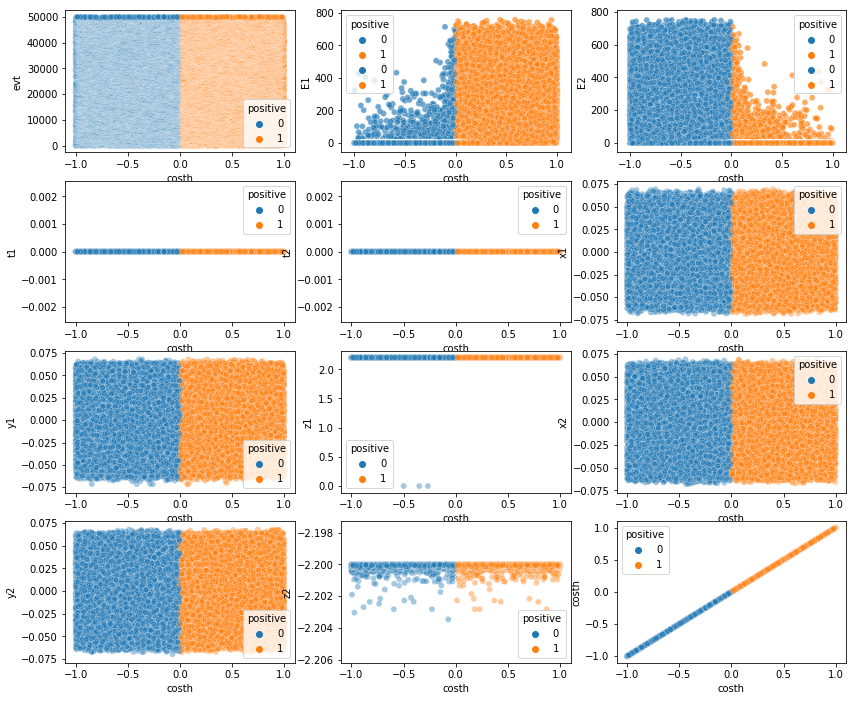

In [46]:
#plotting the feature VS target and looking at the outliers
fig,ax = plt.subplots(4,3, figsize = (14,12))
ax = ax.flatten()
cutOff = 0
train['positive']  = np.where(train['costh'] > 0, 1, 0)
for i, col in enumerate(train.columns):
    if (col == 'E1' or col == 'E2'):
        sns.scatterplot( y = col, x ='costh', data = train,
             ax = ax[i], hue = 'positive',alpha=0.4 )  
        sns.scatterplot( y = col, x = 'costh', data = train,
             ax = ax[i], hue = 'positive',alpha=0.4 )
    else :     
        sns.scatterplot( y = col, x = 'costh', data = train,ax = ax[i],
              hue = 'positive' ,alpha=0.4 )
fig.tight_layout()

~~we notice for E1 E2 there shoudnot hae been any blue (or orange)~~

~~These are the outliers in our experiment. They can be changed by the following ways:~~
1. changing th outlier value with th mean 
---- need to treat these outliers
~~2. remove those E1 where positive is 0~~


In [17]:

#train_set.info()

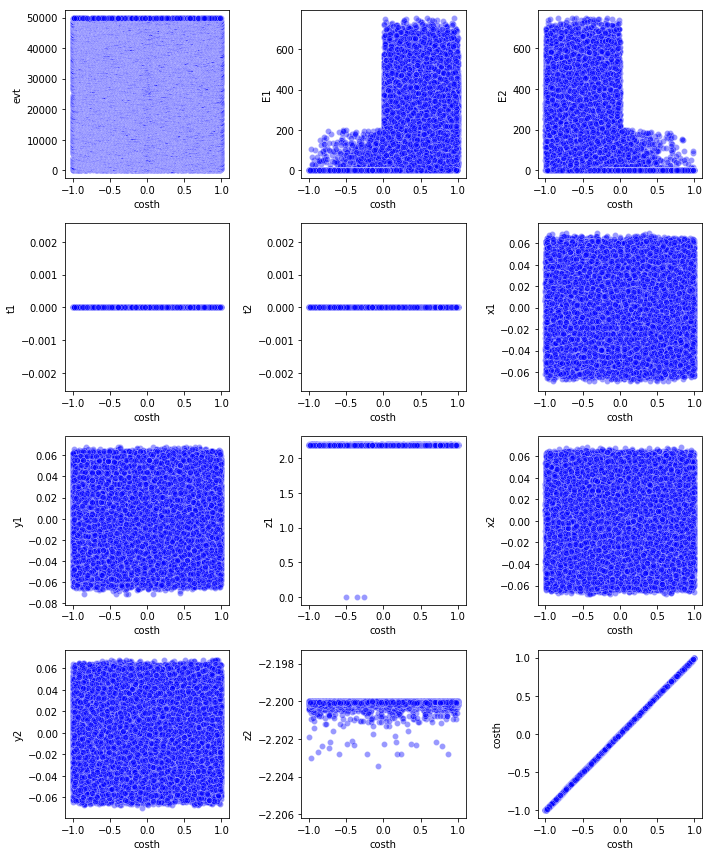

In [22]:
plot_columns(train_set, type = 'scatter')

In [23]:
plot_columns(train_set, type = 'distribution')

: 

: 

doing some transformation
1. boxcox transformation
2. normalise